Design a PI control $C(s)=k_p+k_i/s$ for a time-delay system of the form
$$G(s)=\frac{N(s)}{D(s)}e^{-s\tau}$$
using the cost function
$$J=\int_0^{t_f}\left(\alpha||y(\tau)-r(\tau)||_2^2+\beta||u(\tau)||_2^2\right)d\tau$$
where $y,r,u$ are the output, reference and control force of the system $G$

### Application to a robotic arm
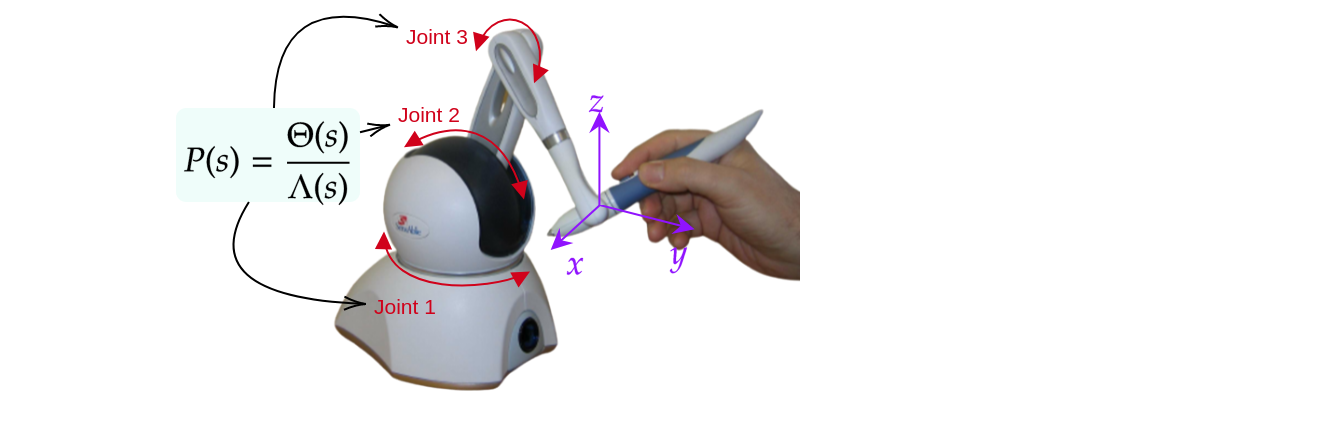

 The dynamics of the haptic system shown in the previous figure can be described by a decoupled time-invariant linear model, with three mechanical admittance describing the dynamics of each joint  
        $$G(s) =\frac{\Theta(s)}{\Lambda(s)}= \frac{e^{-\tau s}}{s(ms+b)} = \frac{e^{-0.1s}}{s(0.0131s+0.0941)},$$
where $\lambda(t)$ represents each torque input and $\theta(t)$ the angular position. Here, the time delay represents the input delay.

In [3]:
import pygad
import numpy
import matplotlib.pyplot as plt
import control as ctl 
from control.matlab import step
from numpy import linalg as LA
import numpy as np

In [25]:
def kp(w,m,b,tau):
    return (w*(m*w*np.cos(tau*w)+b*np.sin(tau*w)))/(np.cos(tau*w)**2+np.sin(tau*w)**2)

def ki(w,m,b,tau):
    return -(m*(w**3)*(np.sin(tau*w)**(-1))-b*(w**2)*(np.tan(tau*w)**(-1))*(np.sin(tau*w)**(-1)))/(1+np.tan(tau*w)**(-2))

Text(0, 0.5, '$k_i$')

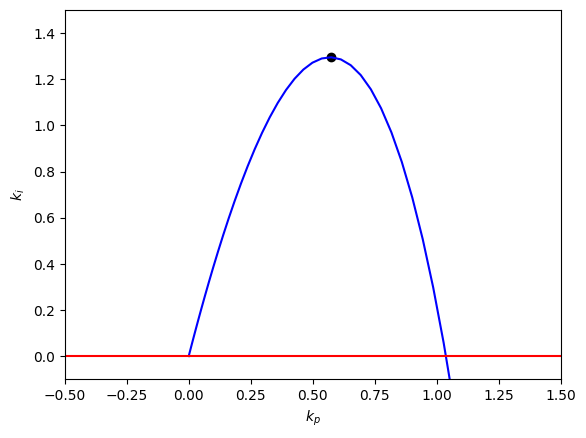

In [53]:
m,b,tau=0.0131, 0.0941, 0.1
w=np.linspace(0.1,20,100)
kp0=np.linspace(-2,2,100)
ki0=0*np.linspace(-2,2,100)
k_i=ki(w,m,b,tau)
k_p=kp(w,m,b,tau)
plt.plot(k_p,k_i,'b')
plt.plot(kp0,ki0,'r')
index=np.argmax(k_i)
plt.scatter(k_p[index],k_i[index],c='k')
plt.ylim([-0.1, 1.5])
plt.xlim([-0.5, 1.5])
plt.xlabel('$k_p$')
plt.ylabel('$k_i$')

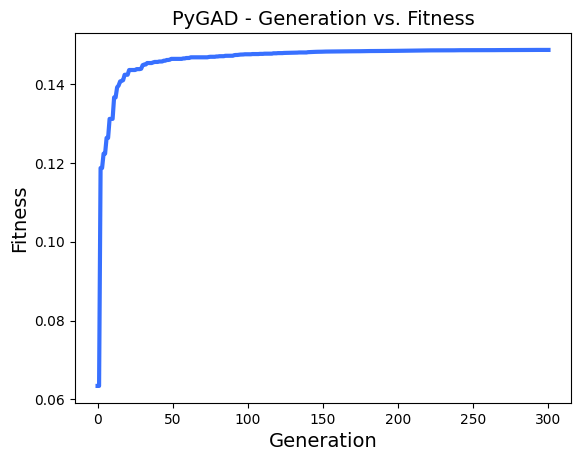

Parameters of the best solution : [ 0.38843869 57.05309767]
Fitness value of the best solution = 0.14866661055857255


In [44]:
desired_output = 0
T = np.linspace(0,5,100)
s = ctl.tf("s")
padenum,padeden=ctl.pade(0.1,5)
delayaprox=ctl.tf(padenum,padeden)
plant = delayaprox/(0.0131*s**2+0.0941*s)

def fitness_f(ga_instance,solution, solution_idx):
    PID_part = solution[0]*(1+1/(solution[1]*s))
    PID_Plant =  ctl.feedback(PID_part*plant)
    force= ctl.feedback(PID_part,plant)
    PID_res,t= step(PID_Plant,T)
    force_res,t=step(force,T)
    #output = LA.norm(numpy.asarray(PID_res)-1)**2 
    output = (LA.norm(numpy.asarray(PID_res)-1)**2 +
                0.2*LA.norm(numpy.asarray(force_res))**2) #lqr
    fitness = 1.0 / numpy.abs(output - desired_output)
    return fitness

fitness_function = fitness_f

num_generations = 300
num_parents_mating = 6

sol_per_pop = 8
num_genes = 2

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()
ga_instance.plot_fitness()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))


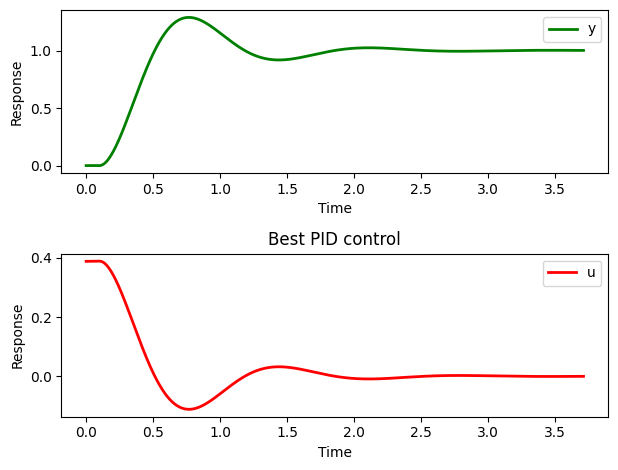

In [45]:
Kp = solution[0]
Ti = solution[1] 
PID_part = Kp*(1+1/(Ti*s))
PID_Plant =  ctl.feedback(PID_part*plant)
PID_res,t = step(PID_Plant)
force= ctl.feedback(PID_part,plant)
force_res,t2=step(force)

fig, axs = plt.subplots(2)
plt.title('Best PID control')
axs[0].plot(t,PID_res,color="green",lw=2,label="y")
axs[1].plot(t2,force_res,color="red",lw=2,label="u")
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Response')
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Response')
#plt.xlim((0,5))
fig.tight_layout()
plt.show()